In [1]:
#All the import stuff (so I don't have to run it every time)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive/ASD_Research/'
data = pd.read_csv(path + 'combined.csv')
print(type(data))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>


In [3]:
#For the dataset
class ASDDataset(Dataset):
  def __init__(self, data, idxmask):

    self.inputs = torch.tensor(data.iloc[:, 0:14].values, dtype = torch.float32)
    self.targets = torch.tensor(data[["ASD_traits"]].values, dtype = torch.float32)
    # make [1] -> [0, 1]
    # make [0] -> [1, 0]
    self.targets = torch.where(
        self.targets == 1,
        torch.tensor(
            [0., 1.],
            dtype=self.targets.dtype),
        torch.tensor([1., 0.], dtype=self.targets.dtype))



  def __str__(self):
    return f"{self.inputs.shape}\n{self.targets.shape}"
  def __len__(self):
    return self.inputs.shape[0]
  def __getitem__(self, index: int):
    return self.inputs[index], self.targets[index]

In [4]:
class Model(nn.Module):
    def __init__(self, edim, heads, num_layers, seed=None):
        super().__init__()

        # Set the seed if provided
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
            # You may also want to set the seed for other libraries if you're using them

        self.encoder = nn.Linear(1, edim)
        self.sas = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=edim, num_heads=heads, batch_first=True)
            for _ in range(num_layers)
        ])
        self.ffs = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(edim),
                nn.Sequential(
                    nn.Linear(edim, 4 * edim),
                    nn.LeakyReLU(),
                    nn.Linear(4 * edim, edim)
                )
            )
            for _ in range(num_layers)
        ])
        self.attn_norms1 = nn.ModuleList([nn.LayerNorm(edim) for _ in range(num_layers)])
        self.attn_norms2 = nn.ModuleList([nn.LayerNorm(edim) for _ in range(num_layers)])
        self.decoder = nn.Linear(edim, 2)

    def forward(self, data):
        data = self.encoder(data)
        for sa, ff, norm1, norm2 in zip(self.sas, self.ffs, self.attn_norms1, self.attn_norms2):
            data = norm1(data + sa(data, data, data)[0])
            data = norm2(data + ff(data))

        data = self.decoder(data)
        data = data.mean(dim=-2)

        # Add noise using the seed-controlled randomness
        data = data + torch.randn_like(data) * 0.1

        # Apply softmax for noise
        data = F.softmax(data, dim=-1)

        return data

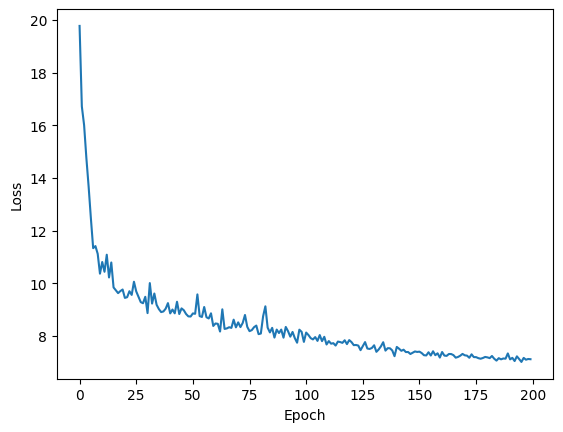

Epoch: 199, Loss: 7.1192954778671265
Test Accuracy: 0.8901734104046243


In [5]:
seed = 3911862233
train_data, test_data = train_test_split(data, test_size=0.2, random_state=345712)
mask = torch.randint(0, 2, (14,), dtype=torch.bool)
idx = torch.arange(0, 14)

# Set the random seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

train_dataset = ASDDataset(train_data, idx[mask])
test_dataset = ASDDataset(test_data, idx[mask])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

model = Model(32, 4, 2, seed=seed)  # Pass the random seed to the model
criterion = nn.BCELoss()
lr_initial = 1e-3
lr_final = 1e-5
epochs = 200
opt = optim.Adam(model.parameters(), lr=lr_initial)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=lr_final)

loss_info = []
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.
    for xinputs, xoutputs in train_loader:
        inputs = xinputs.unsqueeze(-1)
        outputs = xoutputs

        out = model(inputs)
        loss = criterion(out, outputs)
        total_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()

    scheduler.step()
    loss_info.append(total_loss)

    # Plot loss during training
    clear_output(wait=True)
    plt.plot(loss_info)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    print(f"Epoch: {epoch}, Loss: {total_loss}")

    # Testing loop for accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xinputs, xoutputs in test_loader:
            inputs = xinputs.unsqueeze(-1)
            outputs = xoutputs

            out = model(inputs)
            predicted = (out > 0.5).float()
            total += outputs.size(0)
            correct += (predicted == outputs).all(dim=1).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy}")



Epoch 1/200 - Train Accuracy: 0.6673, Val Accuracy: 0.8092
Epoch 1/200 - Train Loss: 0.5991, Val Loss: 0.4623
Epoch 2/200 - Train Accuracy: 0.7623, Val Accuracy: 0.8247
Epoch 2/200 - Train Loss: 0.5065, Val Loss: 0.4276
Epoch 3/200 - Train Accuracy: 0.7792, Val Accuracy: 0.8266
Epoch 3/200 - Train Loss: 0.4850, Val Loss: 0.4233
Epoch 4/200 - Train Accuracy: 0.7985, Val Accuracy: 0.7958
Epoch 4/200 - Train Loss: 0.4471, Val Loss: 0.4510
Epoch 5/200 - Train Accuracy: 0.8230, Val Accuracy: 0.8516
Epoch 5/200 - Train Loss: 0.4141, Val Loss: 0.3581
Epoch 6/200 - Train Accuracy: 0.8554, Val Accuracy: 0.8516
Epoch 6/200 - Train Loss: 0.3775, Val Loss: 0.3276
Epoch 7/200 - Train Accuracy: 0.8693, Val Accuracy: 0.8574
Epoch 7/200 - Train Loss: 0.3435, Val Loss: 0.3292
Epoch 8/200 - Train Accuracy: 0.8660, Val Accuracy: 0.8921
Epoch 8/200 - Train Loss: 0.3458, Val Loss: 0.3009
Epoch 9/200 - Train Accuracy: 0.8722, Val Accuracy: 0.8786
Epoch 9/200 - Train Loss: 0.3369, Val Loss: 0.2966
Epoch 10/2

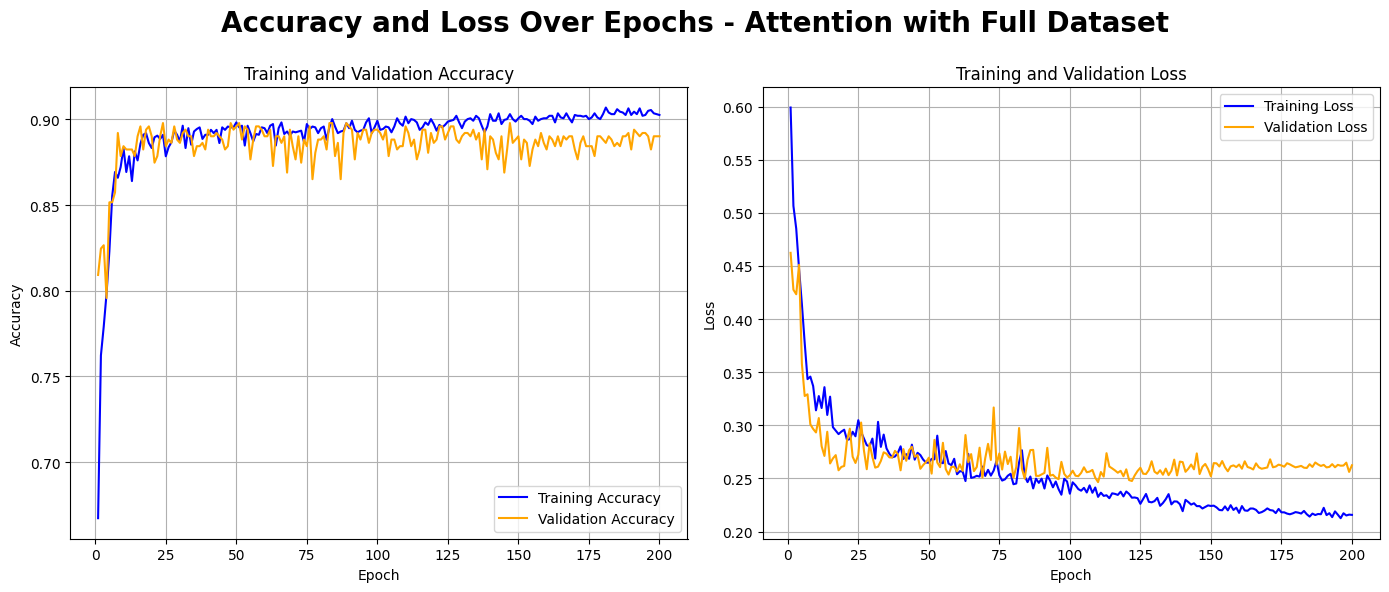

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def plot_train_val_accuracy_and_loss(model_class, train_data, test_data, epochs=200, seed=None):
    """
    Train the model and plot both training and validation accuracy and loss over epochs for one run.

    :param model_class: The model class to train.
    :param train_data: Training dataset.
    :param test_data: Testing dataset.
    :param epochs: Number of epochs for training.
    :param seed: A fixed seed for reproducibility (optional).
    :return: None
    """
    # Set seed for reproducibility if specified
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    # Prepare the datasets
    mask = torch.randint(0, 2, (14,), dtype=torch.bool)
    idx = torch.arange(0, 14)
    train_dataset = ASDDataset(train_data, idx[mask])
    test_dataset = ASDDataset(test_data, idx[mask])
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize the model
    model = model_class(32, 4, 2, seed=seed)
    criterion = nn.BCELoss()
    opt = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-5)

    # Lists to store accuracy and loss values for each epoch
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        correct_train = 0
        total_train = 0
        total_train_loss = 0
        for xinputs, xoutputs in train_loader:
            inputs = xinputs.unsqueeze(-1)
            outputs = xoutputs

            # Forward pass
            out = model(inputs)
            predicted = (out > 0.5).float()

            # Calculate training accuracy
            correct_train += (predicted == outputs).all(dim=1).sum().item()
            total_train += outputs.size(0)

            # Compute loss
            loss = criterion(out, outputs)
            total_train_loss += loss.item()

            # Backward pass and optimization
            opt.zero_grad()
            loss.backward()
            opt.step()

        # Average training accuracy and loss for the epoch
        train_accuracy = correct_train / total_train
        train_loss = total_train_loss / len(train_loader)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        correct_val = 0
        total_val = 0
        total_val_loss = 0
        with torch.no_grad():
            for xinputs, xoutputs in test_loader:
                inputs = xinputs.unsqueeze(-1)
                outputs = xoutputs

                # Forward pass
                out = model(inputs)
                predicted = (out > 0.5).float()

                # Calculate validation accuracy
                correct_val += (predicted == outputs).all(dim=1).sum().item()
                total_val += outputs.size(0)

                # Compute validation loss
                val_loss = criterion(out, outputs)
                total_val_loss += val_loss.item()

        # Average validation accuracy and loss for the epoch
        val_accuracy = correct_val / total_val
        val_loss = total_val_loss / len(test_loader)
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)

        # Print the accuracies and losses every epoch
        print(f"Epoch {epoch+1}/{epochs} - Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Update learning rate
        scheduler.step()

    # Plotting the training and validation accuracy and loss over epochs
    plt.figure(figsize=(14, 6))

    # Add an overarching title for the entire plot
    plt.suptitle('Accuracy and Loss Over Epochs - Attention with Full Dataset', fontsize=20, fontweight='bold')

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss', color='blue')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()

    # Adjust layout to make room for the overarching title
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust top to make space for the suptitle
    plt.show()

# Example usage:
plot_train_val_accuracy_and_loss(Model, train_data, test_data, seed=3911862233)


In [7]:
!pip install torchviz

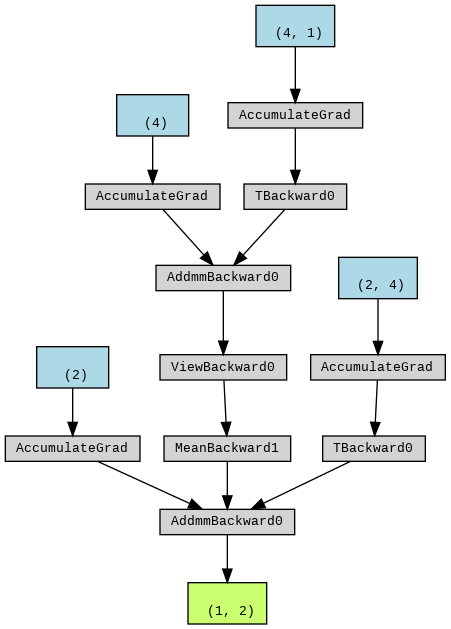

In [8]:
import torch
from torchviz import make_dot
from IPython.display import Image

# Minimalistic model for a super simple graph
class MinimalModel(torch.nn.Module):
    def __init__(self, edim):
        super().__init__()
        self.encoder = torch.nn.Linear(1, edim)
        self.decoder = torch.nn.Linear(edim, 2)

    def forward(self, x):
        x = self.encoder(x)  # Input to embedding
        x = self.decoder(x.mean(dim=1))  # Sequence reduction and decoding
        return x

# Instantiate the minimal model
model = MinimalModel(edim=4)  # Tiny embedding size for fewer operations

# Dummy input
dummy_input = torch.randn(1, 5, 1)  # 1 batch, 5 sequence length, 1 feature

# Forward pass
output = model(dummy_input)

# Generate the most minimal graph
graph = make_dot(output, params=None)  # No parameter details, only essential operations

# Save and display the image
graph.render("minimal_model_architecture", format="png")
Image(filename="minimal_model_architecture.png")
